# Hamilton Load Simulation Demo

This notebook demonstrates using Hamilton to access the load simulation data and manage dataflows.

## Setup

In [1]:
from models import Load, Location, KMA
from datetime import date
import pandas as pd
%matplotlib inline
from hamilton import driver

%load_ext autoreload
%autoreload 1
%aimport dataflows.feature_engineering_dataflow, dataflows.modeling_dataflow, dataflows.offline_etl_dataflow, dataflows.online_inference_dataflow

/home/azureuser/localfiles/datatech-2025-demo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
db_path = "load_simulation_results.db"
feature_store_path = "feature_store.db"
training_cutoff = pd.Timestamp(2025,5,16)

# Explorations

## Load and Explore Data

In [3]:
adapter = driver.Builder().with_modules(dataflows.feature_engineering_dataflow, dataflows.offline_etl_dataflow).build()


In [4]:
result = adapter.execute(['load_data'], inputs={'db_path': db_path})
df = result['load_data']
print(f"Loaded {len(df)} records from the simulation database")
print(f"Data covers from {df['pickup_date'].min()} to {df['pickup_date'].max()}")
print(f"Acceptance rate: {df['is_accepted'].mean():.1%}")
df.head()

Loaded 42500 records from the simulation database
Data covers from 2025-02-03 00:00:00 to 2025-05-30 00:00:00
Acceptance rate: 3.3%


,id,pickup_date,origin_kma,origin_lat,origin_lon,destination_kma,destination_lat,destination_lon,miles,cost,weight,is_accepted
0,56142904-3bc9-4fff-b4f9-2c21d6d7c723,2025-02-03,TX_DAL,32.551714,-96.466467,AZ_PHO,33.252237,-112.523175,1090.0,2474.95,29071.0,False
1,f0b0ee87-073b-45f3-b8a6-823fe4fbd0c0,2025-02-03,MN_MIN,45.061795,-93.342144,IL_CHI,42.037543,-87.538476,418.0,1218.20,43363.0,False
2,15c2f513-27e4-4337-a29a-e1cbd75fcd63,2025-02-03,AZ_PHO,33.271699,-112.253988,IN_IND,39.686093,-86.031759,1774.0,4308.00,29733.0,False
3,81819e4d-018c-4918-94ed-1ef0a612f0cb,2025-02-03,NJ_ELI,40.706808,-74.094930,TX_DAL,32.684084,-96.786722,1601.0,3809.52,40179.0,False
4,baf10567-f3e5-4795-85f8-8bed1841ecd6,2025-02-03,WI_MIL,42.968469,-87.933330,GA_ATL,33.711815,-84.199760,784.0,1350.16,36683.0,False


In [5]:
df.sample(10)[['pickup_date', 'origin_kma', 'destination_kma', 'miles', 'cost', 'weight', 'is_accepted']]

,pickup_date,origin_kma,destination_kma,miles,cost,weight,is_accepted
7452,2025-02-21,TX_HOU,GA_ATL,810.0,2387.45,30770.0,False
29614,2025-04-25,NJ_ELI,TX_HOU,1657.0,3548.41,40155.0,False
35925,2025-05-13,WI_MIL,IL_CHI,110.0,318.83,42321.0,False
30539,2025-04-29,GA_ATL,MN_MIN,1057.0,610.94,32904.0,False
9901,2025-02-28,FL_LAK,NJ_ELI,1165.0,2700.77,27875.0,False
20116,2025-03-31,IN_IND,GA_ATL,491.0,432.10,26438.0,False
12621,2025-03-10,CA_LAX,FL_LAK,2545.0,3017.40,27884.0,False
1766,2025-02-06,IN_IND,GA_ATL,534.0,837.55,25466.0,False
11487,2025-03-05,WI_MIL,GA_ATL,722.0,1470.95,44677.0,False
31961,2025-05-01,CA_LAX,TX_HOU,1613.0,2938.01,33692.0,False


## Simple Features

In [6]:
training_config = {'context': 'training', 'cutoff': training_cutoff}
training_adapter = driver.Builder().with_config(training_config).with_modules(dataflows.feature_engineering_dataflow, dataflows.offline_etl_dataflow).build()


In [7]:
data = training_adapter.execute(['cost', 'miles'], inputs={'db_path': db_path})
data["cost"]

0        2474.95
1        1218.20
2        4308.00
3        3809.52
4        1350.16
          ...   
36995    3552.14
36996    3904.80
36997     728.08
36998    3241.85
36999    1145.81
Name: cost, Length: 37000, dtype: float64

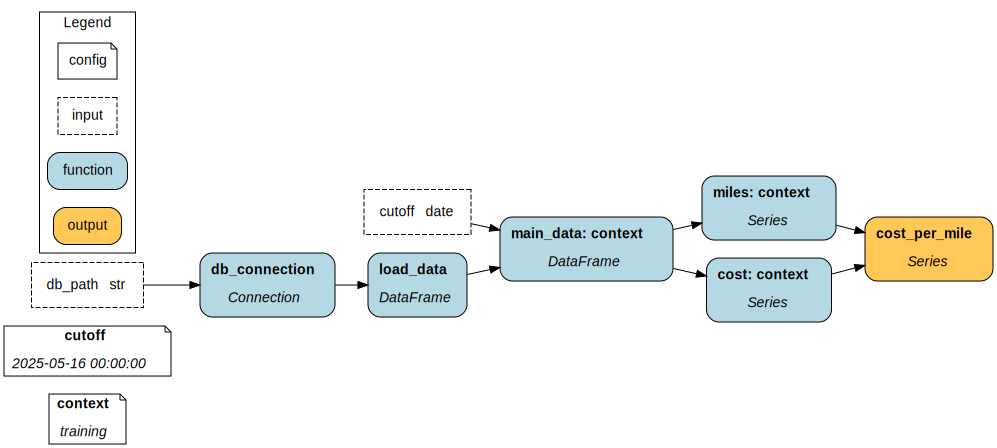

In [8]:
training_adapter.visualize_execution(['cost_per_mile'], inputs={'db_path': db_path})

# Model Training

In [ ]:
features = [
    'cost',
    'miles',
    'weight',
    'cost_per_mile',
    # 'acceptance_forecast',
]
target = 'is_accepted'

## Hydrate the feature store

In [10]:
feature_store_config = {'context': 'feature_store', 'feature_store_path': feature_store_path}
feature_store_adapter = driver.Builder().with_config(feature_store_config).with_modules(dataflows.feature_engineering_dataflow, dataflows.offline_etl_dataflow).build()

In [11]:
feature_store_adapter.execute(['acceptance_forecast'], inputs={'db_path': db_path})

{'acceptance_forecast': None}

## Train the model

### Features

In [12]:
training_config = {'context': 'training', 'cutoff': training_cutoff}
training_inputs = {'db_path': db_path, 'feature_store_path': feature_store_path}
training_adapter = driver.Builder().with_config(training_config).with_modules(dataflows.feature_engineering_dataflow, dataflows.offline_etl_dataflow).build()


In [13]:
training_features_df = pd.DataFrame(training_adapter.execute(features, inputs=training_inputs))
training_target_df = pd.DataFrame(training_adapter.execute([target], inputs=training_inputs))

### Model

In [14]:
model_training_config = {'context': 'training', 'hyperparams': None, 'model_file_path': 'model.pkl'}
model_training_inputs = {'features_df': training_features_df, 'target_df': training_target_df}
model_training_adapter = driver.Builder().with_config(model_training_config).with_modules(dataflows.modeling_dataflow).build()


In [15]:
model_training_adapter.execute(['save_model'], inputs=model_training_inputs)

{'save_model': {}}

# Model evaluation

In [16]:
test_config = {'context': 'testing', 'cutoff': training_cutoff}
test_inputs = {'db_path': db_path, 'feature_store_path': feature_store_path}
test_adapter = driver.Builder().with_config(test_config).with_modules(dataflows.feature_engineering_dataflow, dataflows.offline_etl_dataflow).build()
test_features_df = pd.DataFrame(test_adapter.execute(features, inputs=test_inputs))
test_target_df = pd.DataFrame(test_adapter.execute([target], inputs=test_inputs))

In [17]:
model_evaluation_config = {'model_file_path': 'model.pkl', 'prediction_threshold': 0.5}
model_evaluation_inputs = {'features_df': test_features_df, 'target_df': test_target_df}
model_evaluation_adapter = driver.Builder().with_config(model_evaluation_config).with_modules(dataflows.modeling_dataflow).build()


Accuracy: 98.5%
Precision: 76.2%
Recall: 74.0%


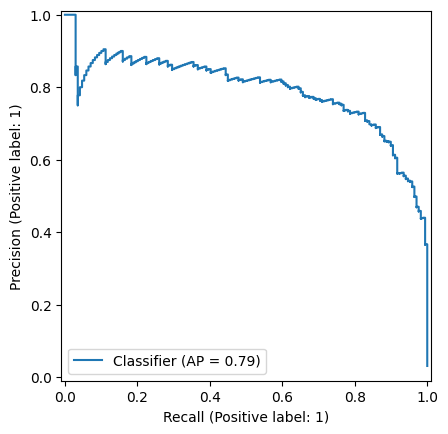

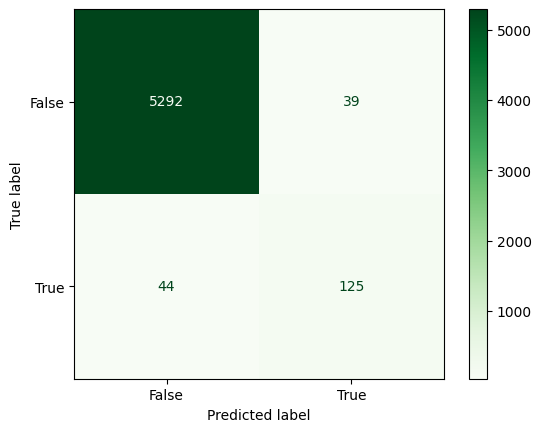

In [18]:
metrics = [
    'accuracy',
    'precision',
    'recall',
    'precision_recall_curve',
    'confusion_matrix',
]
model_evaluation_results = model_evaluation_adapter.execute(metrics, inputs=model_evaluation_inputs)

# Inference

In [19]:
load = Load(
        id="test-load-123",
        origin=Location.from_kma(KMA.CA_LAX),
        destination=Location.from_kma(KMA.CA_STK),
        miles=2000,
        pickup_date=date(2025, 5, 16),
        cost=3500.00,
        weight=8000,
    )

In [20]:
inference_config = {'context': 'inference'}
inference_inputs = {'feature_store_path': feature_store_path, 'load': load}
inference_adapter = driver.Builder().with_config(inference_config).with_modules(dataflows.feature_engineering_dataflow, dataflows.online_inference_dataflow).build()
inference_features_df = pd.DataFrame(inference_adapter.execute(features, inputs=inference_inputs))

In [21]:
model_inference_config = {'model_file_path': 'model.pkl', 'prediction_threshold': 0.5}
model_inference_inputs = {'features_df': inference_features_df}
model_inference_adapter = driver.Builder().with_config(model_inference_config).with_modules(dataflows.modeling_dataflow).build()
model_inference_results = model_inference_adapter.execute(['predicted_probabilities'], inputs=model_inference_inputs)
model_inference_results

{'predicted_probabilities': array([0.91166013], dtype=float32)}